## Wind Power Generation Forecasting
## Cosku Deniz Ozkoc

The aim here is to be able to predict energy generation based on different features. This is a regression problem. This notebook shows how I would approach this problem instead of doing everything. A basic learning algorithm for regression, linear regression with L1 regularization is fit to the given dataset. Root mean squared error is minimized but other metrics can be studied as well like R2 score. R2 score measures the proportion of the variation in the dependent variable explained by the regression model.

In [57]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression

sns.set(color_codes=True)
%matplotlib inline
seed = 1

In [2]:
data = pd.read_csv('data/dataset.csv', index_col='DateTime', parse_dates=True)

In [3]:
data.head()

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Prod
DateTime,,,,,,,,,
2013-04-01 03:00:00,12.6,12.6,81.0,12.6,76.0,1008.0,245.0,1.94,0.028169
2013-04-01 04:00:00,13.0,13.0,91.0,13.0,78.0,1009.0,215.0,2.28,0.028169
2013-04-01 05:00:00,12.9,12.9,98.0,12.9,80.0,1009.0,194.0,2.17,0.021127
2013-04-01 06:00:00,12.7,12.7,100.0,12.7,81.0,1009.0,179.0,1.97,0.070423
2013-04-01 07:00:00,13.0,13.0,96.0,13.0,80.0,1008.0,162.0,2.08,0.035211


In [4]:
test_data = pd.read_csv('data/test.csv', index_col='DateTime', parse_dates=True)
test_data.head()

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Prod
DateTime,,,,,,,,,
2017-10-01 00:00:00,14.3,14.3,100,14.3,93,1016,331,2.86,NaN
2017-10-01 01:00:00,14.1,14.1,100,14.1,93,1016,332,3.03,NaN
2017-10-01 02:00:00,13.9,13.9,100,13.9,94,1016,334,3.11,NaN
2017-10-01 03:00:00,13.7,13.7,100,13.7,93,1016,334,3.19,NaN
2017-10-01 04:00:00,14.0,14.0,100,14.0,95,1016,325,3.08,NaN


### EDA (Exploratory Data Analysis)

In [5]:
print('Training set consists of %d data points' %len(data))

Training set consists of 36355 data points


In [6]:
print('Test set consists of %d data points' %len(test_data))

Test set consists of 2928 data points


In [7]:
data.isnull().sum()

AppTemperature    2928
Temperature       2928
CloudCover        2928
DewPoint          2928
Humidity          2928
Pressure          2928
WindBearing       2928
WindSpeed         2928
Prod              2928
dtype: int64

In [8]:
data.index.isnull().sum()

2928

There are 2928 missing values in every column and in the index. 

In [9]:
test_data.isnull().sum()

AppTemperature       0
Temperature          0
CloudCover           0
DewPoint             0
Humidity             0
Pressure             0
WindBearing          0
WindSpeed            0
Prod              2928
dtype: int64

In [10]:
test_data.index.isnull().sum()

0

In [11]:
data[data.isnull().any(axis=1)]

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Prod
DateTime,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems like all the values are missing for these data points so they cannot be used at all. Let's verify this. 

In [12]:
data[data.isnull().any(axis=1)].isnull().all(axis=1).all()

True

All the values in these rows are missing as can be seen above. Let's get rid of them. 

In [13]:
data.dropna(how='all', inplace=True)

In [14]:
data.isnull().sum()

AppTemperature    0
Temperature       0
CloudCover        0
DewPoint          0
Humidity          0
Pressure          0
WindBearing       0
WindSpeed         0
Prod              0
dtype: int64

In [15]:
data.index.isnull().sum()

0

No missing values left. Those values are missing because they are put into the test set probably.

In [16]:
print('Training set consists of %d data points after missing rows are removed' %len(data))

Training set consists of 33427 data points after missing rows are removed


In [17]:
data.index.duplicated().any()

True

In [18]:
data.index[data.index.duplicated()]

DatetimeIndex(['2013-10-27 03:00:00', '2015-11-08 03:00:00'], dtype='datetime64[ns]', name='DateTime', freq=None)

In [19]:
data[data.index.isin(['2013-10-27 03:00:00', '2015-11-08 03:00:00'])]

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Prod
DateTime,,,,,,,,,
2013-10-27 03:00:00,8.7,9.7,39.0,8.7,96.0,1022.0,8.0,2.14,0.126761
2013-10-27 03:00:00,8.6,9.6,44.0,8.6,97.0,1021.0,8.0,2.19,0.126761
2015-11-08 03:00:00,10.9,10.9,98.0,10.9,90.0,1025.0,8.0,3.47,0.443662
2015-11-08 03:00:00,11.0,11.0,96.0,11.0,91.0,1025.0,359.0,2.94,0.443662


__As can be seen above there are duplicated values for the dates 2013-10-27 03:00:00 and 2015-11-08 03:00:00. One of the measurents for those dates should be incorrect. Unfortunately it is not known which one. So let's get rid one of them. But this should be checked with the person who was responsible for recording the measurements. Below the second duplicated values are removed.__ 

In [20]:
data = data[~data.index.duplicated()]

In [21]:
data[data.index.isin(['2013-10-27 03:00:00', '2015-11-08 03:00:00'])]

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Prod
DateTime,,,,,,,,,
2013-10-27 03:00:00,8.7,9.7,39.0,8.7,96.0,1022.0,8.0,2.14,0.126761
2015-11-08 03:00:00,10.9,10.9,98.0,10.9,90.0,1025.0,8.0,3.47,0.443662


In [22]:
print('Training set consists of %d data points after duplicates are removed' %len(data))

Training set consists of 33425 data points after duplicates are removed


In [23]:
test_data.index.duplicated().any()

False

There are no duplicated date values in the test set. 

In [24]:
print('The time frame is from {} to {} for the training data'.format(data.index.min(), data.index.max()))

The time frame is from 2013-04-01 03:00:00 to 2017-09-30 23:00:00 for the training data


In [25]:
print('The time frame is from {} to {} for the test data'.format(test_data.index.min(), test_data.index.max()))

The time frame is from 2017-10-01 00:00:00 to 2018-01-31 23:00:00 for the test data


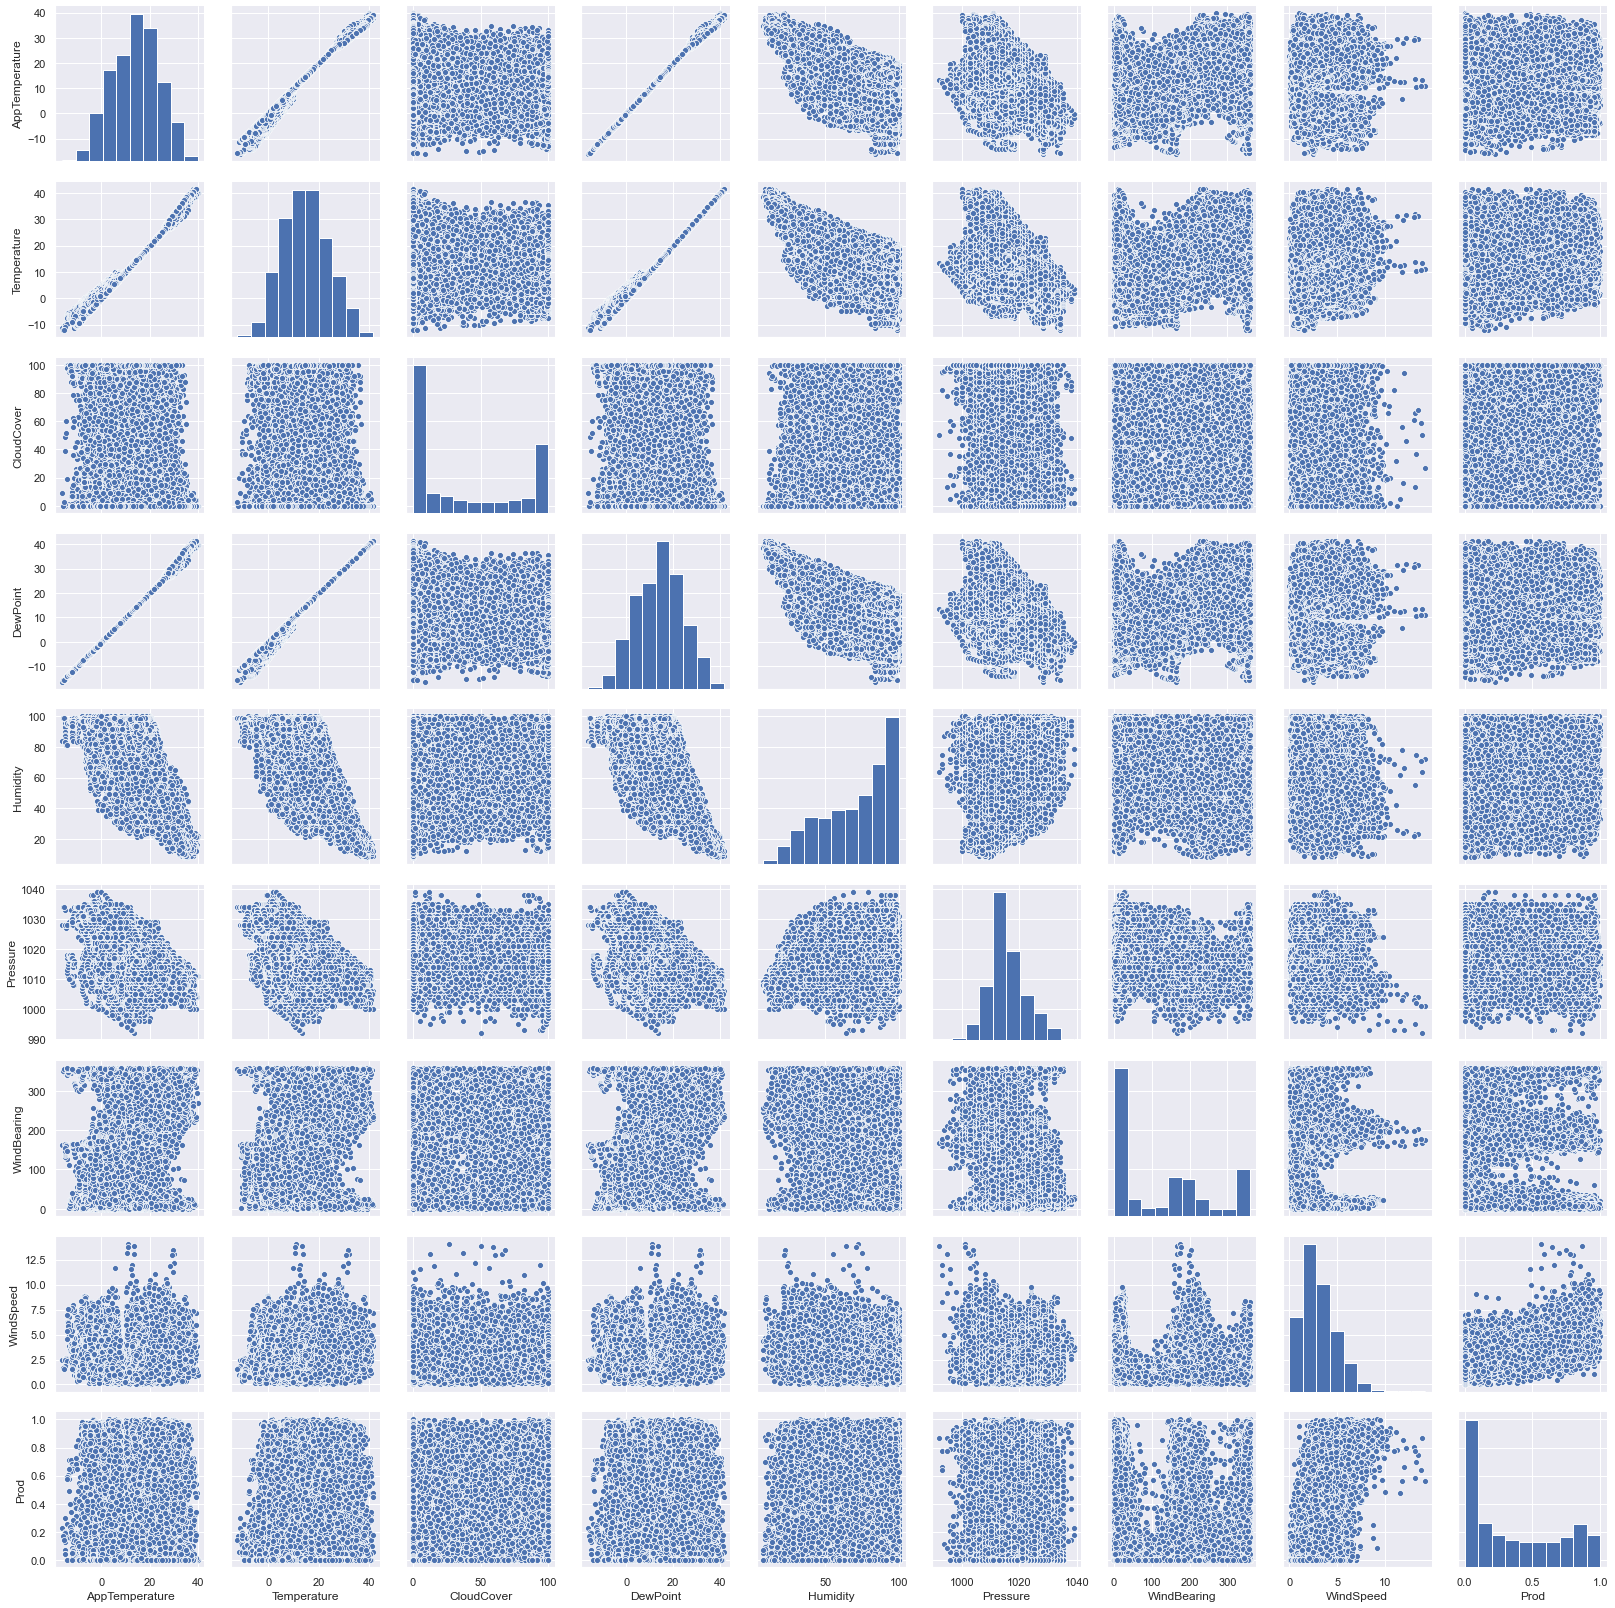

In [26]:
sns.pairplot(data=data)

As can be seen from the pairplot above, the distributions of the 'AppTemperature', 'Temperature', 'DewPoint' and 'Pressure' seem like normally distributed. However the values for 'CloudCover' are mostly concentrated towards the extreme values. The distibutions for 'Prod', 'WindSpeed', 'WindBearing' and 'Humidity' do not follow a normal distribution like the 'CloudCover'. Different transofrmations can be applied to make these distributions approximately Gaussian and this may help in models like linear regression but this will be left as a future work.   

From the pair plots above, it can be seen that 'Temperature' and 'AppTemperature' are highly correlated. Also 'Temperature' and 'AppTemperature' are highly correlated with 'DewPoint' as well. Let's look at the correlation of the data as below.  

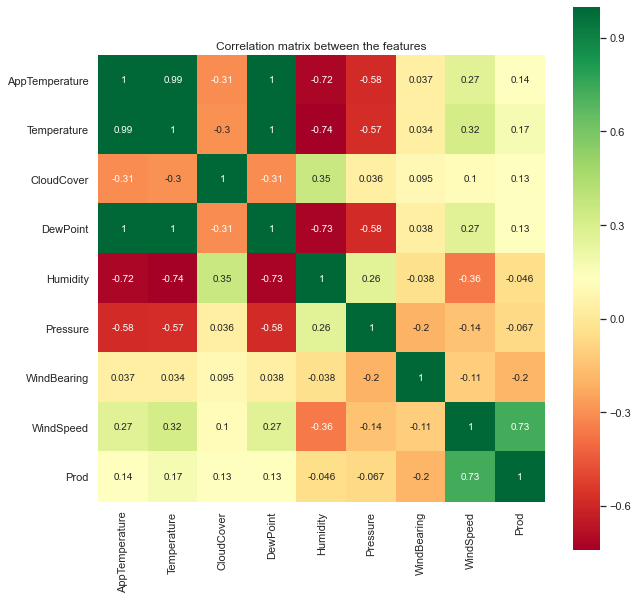

In [27]:
correlation_matrix = data.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdYlGn')
plt.title('Correlation matrix between the features')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

The correlation matrix above confirms the results obtained from the pair plot. The correlation between 'DewPoint' and 'Temperature' is 1 as well as the correlation between 'DewPoint' and 'AppTemperature'. The correlation between 'Temperature' and 'AppTemperature' is 0.99. In terms of making correct predictions, these correlations will not affect the results. However, if the coefficients assigned to these features should be studied to see which features are important, including or not including highly correlated features will make a big impact on the cofficient values. Also humidity is negatively correlated with 'Temperature', 'AppTemperature' and 'DewPoint'. This observation can be made from the pair plots as well. 'WindSpeed' is strongly correlated with the energy production as expected and should definitely be included in a model for making predictions. Also 'Pressure' is negatively correlated with 'Temperature', 'AppTemperature' and 'DewPoint'.     

Let's plot the energy production vs time as shown below. 

In [28]:
data.index.is_monotonic_increasing

True

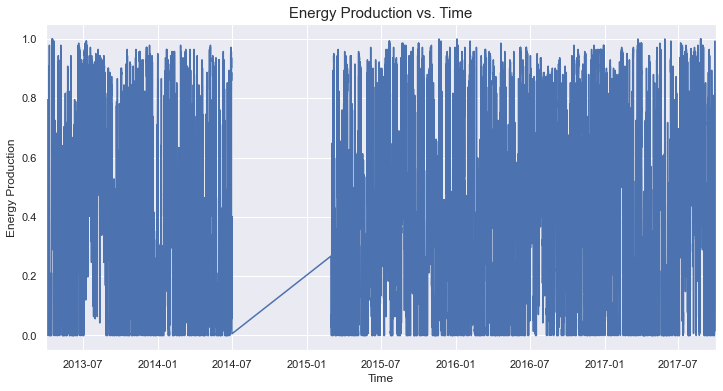

In [29]:
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(data.index, data.Prod)

ax.set_xlim(data.index[0], data.index[-1])

ax.set_ylabel('Energy Production', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.set_title('Energy Production vs. Time', fontsize=15)
plt.show()

In [30]:
data['2014-07':'2015-02']

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Prod
DateTime,,,,,,,,,


As can be seen above, there is a gap and there are no measurements between July 2014 to February 2015 including February 2015. In order to find out why this is the case, the person who is responsible for recording the measurements should be contacted.  

Let's focus on shorter portions of the timeframe. Below the energy production for 1 year is looked at between July 2015 and July 2016 not including July 2016.

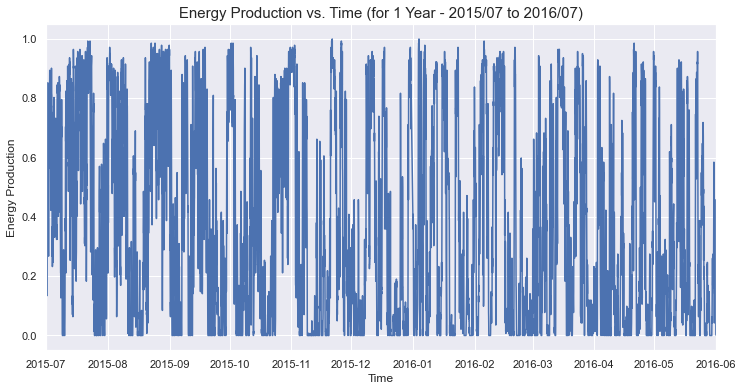

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(data.index[(data.index >= '2015-07') & (data.index <= '2016-06')], data.Prod[(data.index >= '2015-07') & (data.index <= '2016-06')])

ax.set_xlim(data.index[(data.index >= '2015-07') & (data.index <= '2016-06')][0], data.index[(data.index >= '2015-07') & (data.index <= '2016-06')][-1])

ax.set_ylabel('Energy Production', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.set_title('Energy Production vs. Time (for 1 Year - 2015/07 to 2016/07)', fontsize=15)
plt.show()

From the plot above it is seen that the frequency of oscillation is high.

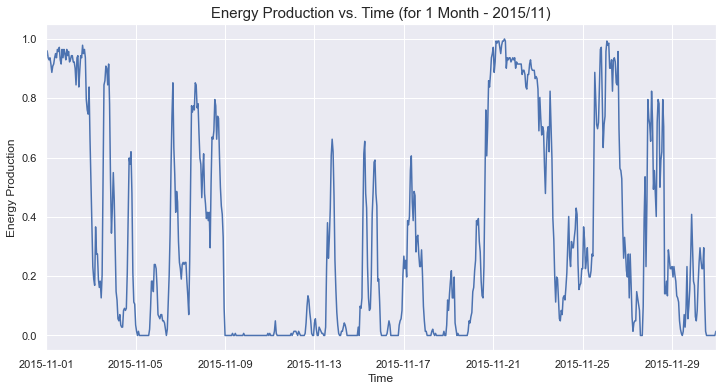

In [32]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(data['2015-11'].index, data['2015-11']['Prod'])

ax.set_xlim(data['2015-11'].index[0], data['2015-11'].index[-1])

ax.set_ylabel('Energy Production', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.set_title('Energy Production vs. Time (for 1 Month - 2015/11)', fontsize=15)
plt.show()

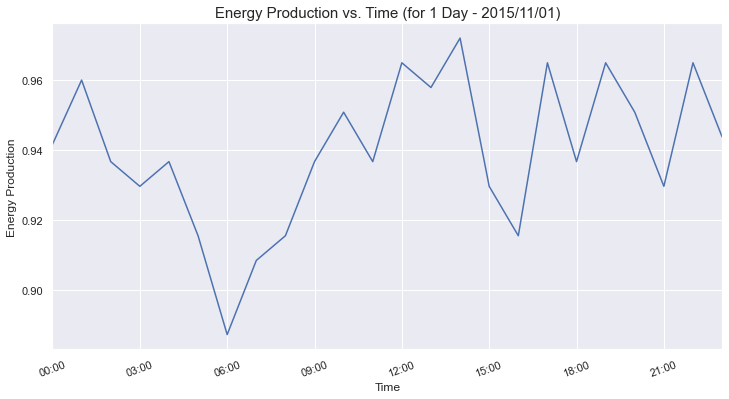

In [33]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(data['2015-11-01'].index, data['2015-11-01']['Prod'])

ax.set_xlim(data['2015-11-01'].index[0], data['2015-11-01'].index[-1])

ax.set_ylabel('Energy Production', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.set_title('Energy Production vs. Time (for 1 Day - 2015/11/01)', fontsize=15)
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation=20)
plt.show()

Different time frames can be studied as well to see if there are any pecularities but this will not be studied further.  

### Training ML Models

Since accurate prediction is the goal, correlation will not be looked into but correlated features can be taken out of the features without changing the predictions much. However, the values of the coeficients assigned to the correlated features will definitely change if correlated features will be taken out of the dataset. Let's train linear regression with L1 regularization. L1 regularization should get rid of the correlated features anyway resulting in sparser features.    

Let's prepare the training data for linear regression. 

In [34]:
data.reset_index(inplace=True)

In [35]:
data['Years'] = data.DateTime.map(lambda x: x.year)
data['Months'] = data.DateTime.map(lambda x: x.month)
data['Days'] = data.DateTime.map(lambda x: x.day)
data['Hours'] = data.DateTime.map(lambda x: x.hour)

In [36]:
target = np.asarray(data.Prod)

In [37]:
data.drop(['DateTime', 'Prod'], axis=1, inplace=True)

In [38]:
data.head()

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Years,Months,Days,Hours
0,12.6,12.6,81.0,12.6,76.0,1008.0,245.0,1.94,2013,4,1,3
1,13.0,13.0,91.0,13.0,78.0,1009.0,215.0,2.28,2013,4,1,4
2,12.9,12.9,98.0,12.9,80.0,1009.0,194.0,2.17,2013,4,1,5
3,12.7,12.7,100.0,12.7,81.0,1009.0,179.0,1.97,2013,4,1,6
4,13.0,13.0,96.0,13.0,80.0,1008.0,162.0,2.08,2013,4,1,7


Let's use one hot encoding for the days, months and hours. One hot encoding can be used for the years as well but in the test set there are years that are not included in the training set so one hot encoding will not learn any coefficents for the years in the test set that are not included in the training set.

In [39]:
print('Unique years in the test set\n{}'.format(np.unique(test_data.index.year)))

Unique years in the test set
[2017 2018]


In [40]:
print('Unique years in the training set\n{}'.format(np.unique(data.Years)))

Unique years in the training set
[2013 2014 2015 2016 2017]


In [41]:
print('Unique hours in the test set\n{}'.format(np.unique(test_data.index.hour)))

Unique hours in the test set
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [42]:
print('Unique hours in the training set\n{}'.format(np.unique(data.Hours)))

Unique hours in the training set
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [43]:
print('Unique days in the test set\n{}'.format(np.unique(test_data.index.day)))

Unique days in the test set
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


In [44]:
print('Unique days in the training set\n{}'.format(np.unique(data.Days)))

Unique days in the training set
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


In [45]:
print('Unique months in the test set\n{}'.format(np.unique(test_data.index.month)))

Unique months in the test set
[ 1 10 11 12]


In [46]:
print('Unique months in the training set\n{}'.format(np.unique(data.Months)))

Unique months in the training set
[ 1  2  3  4  5  6  7  8  9 10 11 12]


In [47]:
featuresLR = data.values
featuresLR.shape

(33425, 12)

In [48]:
featuresMonths = ['Month_%d' %m for m in np.unique(data.Months)] 
featuresDays = ['Day_%d' %d for d in np.unique(data.Days)]
featuresHours = ['Hour_%d' %h for h in np.unique(data.Hours)]
features = featuresMonths + featuresDays + featuresHours

Cross-validation can be used with time-series data using the TimeSeriesSplit. 

In [49]:
tscv = TimeSeriesSplit()

In [50]:
alphas = np.logspace(-4, 4, 30)

ct1 = ColumnTransformer([("scaling", StandardScaler(), list(range(9))), 
                         ("onehot", OneHotEncoder(sparse=False, categories=[np.unique(data.Months), 
                                                                            np.unique(data.Days), 
                                                                            np.unique(data.Hours)]), 
                          list(range(-3,0)))])

ct2 = ColumnTransformer([("polynomial", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), 
                         list(range(9,len(features)+9)))], remainder='passthrough')

In [51]:
regLasso = Lasso()

paramLasso = {'Lasso__alpha': alphas}

pipeLasso = Pipeline(steps=[('CT1', ct1), ('CT2', ct2), ('Lasso', regLasso)])

gsregLasso = GridSearchCV(estimator=pipeLasso, param_grid=paramLasso, cv=tscv, 
                          scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', 
                          return_train_score=True, n_jobs=-1)

start = time.time()
gsregLasso.fit(featuresLR, target)
end = time.time()

/Users/coskudeniz/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


__This is a warning only and does not result in different parameter selections.__

In [52]:
print(gsregLasso.best_params_)
index = gsregLasso.cv_results_['mean_test_neg_mean_squared_error'].argmax()
print('Time needed for training: {:.2f} minutes'.format((end - start)/60))
print('RMSE on training data: %.2f' %np.sqrt(-gsregLasso.cv_results_['mean_train_neg_mean_squared_error'][index]))
print('RMSE on validation data: %.2f' %np.sqrt(-gsregLasso.best_score_))
print('R2 score returned on the validation data for the parameters that optimize MSE is %.2f' 
      %gsregLasso.cv_results_['mean_test_r2'][index])

{'Lasso__alpha': 0.0006723357536499335}
Time needed for training: 6.55 minutes
RMSE on training data: 0.19
RMSE on validation data: 0.20
R2 score returned on the validation data for the parameters that optimize MSE is 0.63


GridSearchCV fits the selected model on all the available data after the selection process is over. 

In [53]:
featureNames = gsregLasso.best_estimator_.named_steps['CT2'].named_transformers_['polynomial'].get_feature_names(features) + data.columns.to_list()[:9]

Lasso picked 42 variables and eliminated the other 2245 variables


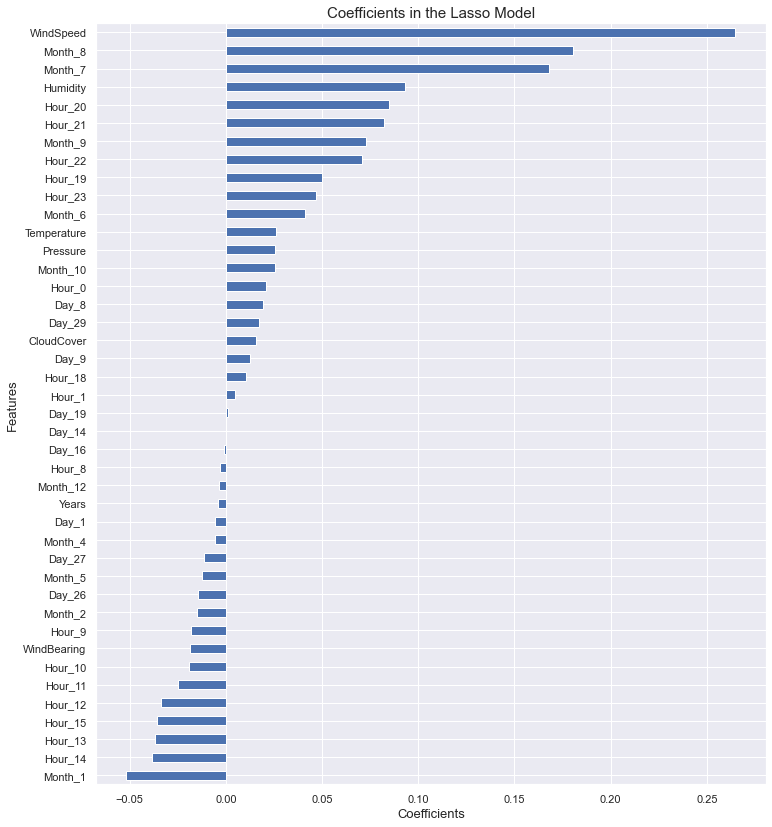

In [55]:
coef = pd.Series(gsregLasso.best_estimator_.named_steps['Lasso'].coef_, index = featureNames)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")
imp_coef = coef[coef != 0].sort_values()
fig, ax = plt.subplots(1, 1, figsize=(12, 14))
imp_coef.plot(kind = "barh", ax=ax)
ax.set_title("Coefficients in the Lasso Model", fontsize=15)
ax.set_xlabel('Coefficients', fontsize=13)
ax.set_ylabel('Features', fontsize=13)
plt.show()

As expected windspeed is the feature with the highest coefficient value since it is the feature that has the highest correlation with the target value. Also as seen from the figure above, Lasso only picks 'Temperature' and does not pick 'AppTemperature' or 'DewPoint' since these three features are highly correlated with each other. 

As can be seen below, the Lasso model does a much better job then just predicting the mean value. 

In [60]:
RMSE = 0
R2 = 0
cv = 0
for train, test in tscv.split(target):
    predicted = np.mean(target[train])
    RMSE += np.sqrt(mean_squared_error(target[test], np.ones(len(test))*predicted))
    R2 += r2_score(target[test], np.ones(len(test))*predicted)
    cv += 1
print('If mean value will be predicted always:\nRMSE on validation data will be %.2f\nR2 score on validation data will be %.2f' %(RMSE/cv, R2/cv))

If mean value will be predicted always:
RMSE on validation data will be 0.34
R2 score on validation data will be -0.05


If we train only on windspeed using Linear Regression, the results are as shown below. 

In [62]:
lr = LinearRegression()

pipeLR = Pipeline(steps=[('scaler', StandardScaler()), ('LR', lr)])

resultLR = cross_validate(lr, featuresLR[:,7].reshape(-1,1), target, cv=tscv, return_train_score=True, 
                          scoring=['neg_mean_squared_error', 'r2'], n_jobs=-1)

In [65]:
print('Training RMSE: %.2f' %np.sqrt(-np.mean(resultLR['train_neg_mean_squared_error'])))
print('RMSE of validation data: %.2f' %np.sqrt(-np.mean(resultLR['test_neg_mean_squared_error'])))
print('R2 score on validation data: %.2f' %np.mean(resultLR['test_r2']))

Training RMSE: 0.23
RMSE of validation data: 0.23
R2 score on validation data: 0.52


Since Lasso model results in better metrics on the validation data, it will be used for predicting unseen data. Let's make the predictions for the test set as done below.    

In [66]:
test_data.index.is_monotonic_increasing

True

In [67]:
X_test = test_data.reset_index()
X_test['Years'] = X_test.DateTime.map(lambda x: x.year)
X_test['Months'] = X_test.DateTime.map(lambda x: x.month)
X_test['Days'] = X_test.DateTime.map(lambda x: x.day)
X_test['Hours'] = X_test.DateTime.map(lambda x: x.hour)
X_test.drop(['Prod', 'DateTime'], axis=1, inplace=True)

In [68]:
X_test.head()

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Years,Months,Days,Hours
0,14.3,14.3,100,14.3,93,1016,331,2.86,2017,10,1,0
1,14.1,14.1,100,14.1,93,1016,332,3.03,2017,10,1,1
2,13.9,13.9,100,13.9,94,1016,334,3.11,2017,10,1,2
3,13.7,13.7,100,13.7,93,1016,334,3.19,2017,10,1,3
4,14.0,14.0,100,14.0,95,1016,325,3.08,2017,10,1,4


In [69]:
X_test = X_test.values

In [70]:
predictions = gsregLasso.predict(X_test)

In [71]:
predictions

array([0.41649186, 0.4256753 , 0.4365501 , ..., 0.11545461, 0.09611165,
       0.10340967])

In [72]:
test_data.Prod = predictions
test_data.head()

,AppTemperature,Temperature,CloudCover,DewPoint,Humidity,Pressure,WindBearing,WindSpeed,Prod
DateTime,,,,,,,,,
2017-10-01 00:00:00,14.3,14.3,100,14.3,93,1016,331,2.86,0.416492
2017-10-01 01:00:00,14.1,14.1,100,14.1,93,1016,332,3.03,0.425675
2017-10-01 02:00:00,13.9,13.9,100,13.9,94,1016,334,3.11,0.436550
2017-10-01 03:00:00,13.7,13.7,100,13.7,93,1016,334,3.19,0.444165
2017-10-01 04:00:00,14.0,14.0,100,14.0,95,1016,325,3.08,0.437657


In [73]:
test_data.to_csv('TestDataWithPredictedValues')

### Conclusion and Future Work

The problem is underfitting when linear regression with L1 regularization is used. In order to solve the underfitting problem more complex models like SVMs, Random Forests, Boosting algorithms can be used. Also linear regression without any regularization can be tried as well. Here, linear regression is trained only using the 'Windspeed' feature and this model can be trained using all the features. Also LSTMs can be a good approach considering underfitting is the problem but the data may not be considered as a large dataset for training deep learning models. 

Since generalization error is not to be reported only cross validation is used for grid search and model selection purposes. If generalization error should be reported as well, dataset should be divided into two sets first. Training set and test set. Test set can be used for reporting the generalization error. For grid search and model selection, training set can be further divided in itself to training set and validation set.  